In [18]:
from functools import reduce
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import unicodedata

import pandas as pd
import numpy as np
import time
import json
from pathlib import Path

import csv
import re

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()

In [19]:
dataset_folder_name = 'dataset_parsed'

dataset_path = Path(dataset_folder_name)

# Check if the the dataset folder exists
dataset_path.is_dir()

True

In [20]:
dataset_load_path = Path('dataset_prediction')

dataset_load_path = dataset_load_path / 'estates_with_facilities.csv'
assert dataset_load_path.is_file()

estates_with_facilities_df = pd.read_csv(
    str(dataset_load_path),
    quoting=csv.QUOTE_ALL,
    sep=',',
    index_col=0
)

estates_with_facilities_df

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id                                     name  \
0     1919821916                Pronájem bytu 1+kk 42 m2   
1     1010014300                Pronájem bytu 2+kk 40 m2   
2     2734897244                 Pronájem bytu 1+1 29 m2   
3     2175342684                Pronájem bytu 2+kk 45 m2   
4     3571591260                 Pronájem bytu 1+1 32 m2   
...          ...                                      ...   
8620  4180359260                Pronájem bytu 2+1 124 m2   
8621  3466005340                 Pronájem bytu 2+1 67 m2   
8622  3489044572  Pronájem bytu 2+kk 110 m2 (Podkrovní)   
8623   259754076                Pronájem bytu 2+kk 57 m2   
8624   940832860                  Pronájem  pokoje 20 m2   

                                          location  price  \
0                        Reissigova, Brno - Ponava  12500   
1     Bedřicha Smetany, Plzeň - Vnitřní Město  11000   
2                    Hybešova, Brno - Staré Brno  10200   
3            Palackého nám., Dačice - Dačice I   7500   
4                       Kounicova, Brno - Veveří  11500   
...                                            ...    ...   
8620                        Praha 2 - Nové Město  25000   
8621              Purkyňova, Brno - Královo Pole  12900   
8622                               Leska, Dobšice   8500   
8623                   Kytlická, Praha 9 - Prosek  15000   
8624          Vsetínská, Valašské Meziříčí   6900   

              Celková cena:  \
0     12 500 Kč za měsíc   
1     11 000 Kč za měsíc   
2     10 200 Kč za měsíc   
3      7 500 Kč za měsíc   
4     11 500 Kč za měsíc   
...                     ...   
8620  25 000 Kč za měsíc   
8621  12 900 Kč za měsíc   
8622   8 500 Kč za měsíc   
8623  15 000 Kč za měsíc   
8624   6 900 Kč za měsíc   

                                       Poznámka k ceně: ID zakázky:  \
0     vratná jistota 15 000 Kč, náklady na bydlen...       N2589   
1     + poplatky 2.000,-Kč + elektrickou en. na vla...    yTSB7431   
2     vratná jistota 15 000 Kč, náklady na bydlen...       N2577   
3     +2000 Kč energie +  vratná kauce v ceně jed...       00686   
4                 2 500 Kč služby/měs., + provize RK       00116   
...                                                 ...         ...   
8620  + služby a poplatky cca 5.000,- Kč, kauce, p...      A09939   
8621          + 3000 zálohy na energie, vodu a služby         NaN   
8622                       + poplatky (uvedeno v textu)       00263   
8623  Cena uvedena bez poplatků 2.000,- Kč/měs. +...         409   
8624                včetně energií; kauce 13.800 Kč       N1274   

     Aktualizace:     Stavba:    Stav objektu: Vlastnictví:  \
0      2022-01-03    Cihlová       Novostavba      Osobní   
1      2022-01-10    Cihlová     Velmi dobrý      Osobní   
2      2022-01-07    Cihlová           Dobrý      Osobní   
3      2022-01-07    Cihlová     Velmi dobrý      Osobní   
4      2022-01-04    Cihlová     Velmi dobrý      Osobní   
...           ...         ...              ...          ...   
8620   2022-01-05    Cihlová     Velmi dobrý      Osobní   
8621   2022-01-10    Cihlová  Po rekonstrukci      Osobní   
8622   2022-01-10    Cihlová     Velmi dobrý      Osobní   
8623   2022-01-05  Skeletová     Velmi dobrý      Osobní   
8624   2021-12-01    Cihlová           Dobrý      Osobní   

        Umístění objektu:                                        Podlaží:  \
0     Klidná část obce                         5. podlaží z celkem 8   
1                     NaN                                    2. podlaží   
2                     NaN                         1. podlaží z celkem 3   
3                     NaN                                    1. podlaží   
4                     NaN                         4. podlaží z celkem 6   
...                   ...                                             ...   
8620                  NaN 

In [21]:
descriptions_file_name = 'descriptions.json'

descriptions = json.load(open(dataset_path / descriptions_file_name, 'r'))

In [22]:
# So that we see all columns in dataframes
pd.set_option('display.max_columns', None)


We want to predict flat rent prices. We have explored the dataset and saw that it has many useful features. We have studied correlation between price and single features, but now we will combine them and see the compound effect of them and then we will study their predictive power. 

First of all, we have to decide, which features (= columns) will be used in the predictor. Prediction generally works in a way that an analyst carefully studies all features that he has and decides if these features make sense. EDA above will help. Here we study mostly missing data and data imputation or suggestions on how to improve the quality of the dataset. 

The cells below show a typical process of feature-engineering - a careful process of studying each feature and decision whether to include them into model or not. By doing this frankly speaking painful process an analyst can trust the model and be trusted by stakeholders. 

To remind. We have these two data sources:

    - estates_with_facilities_df - a large dataframe with parsed table from the webs and appended facilities from another table on the respective page.
    - descriptions - a JSON list with textual descriptions of flats which has lots of useful information that can be utilised for missing data imputation.

In [23]:
df = estates_with_facilities_df
df

id                                     name  \
0     1919821916                Pronájem bytu 1+kk 42 m2   
1     1010014300                Pronájem bytu 2+kk 40 m2   
2     2734897244                 Pronájem bytu 1+1 29 m2   
3     2175342684                Pronájem bytu 2+kk 45 m2   
4     3571591260                 Pronájem bytu 1+1 32 m2   
...          ...                                      ...   
8620  4180359260                Pronájem bytu 2+1 124 m2   
8621  3466005340                 Pronájem bytu 2+1 67 m2   
8622  3489044572  Pronájem bytu 2+kk 110 m2 (Podkrovní)   
8623   259754076                Pronájem bytu 2+kk 57 m2   
8624   940832860                  Pronájem  pokoje 20 m2   

                                          location  price  \
0                        Reissigova, Brno - Ponava  12500   
1     Bedřicha Smetany, Plzeň - Vnitřní Město  11000   
2                    Hybešova, Brno - Staré Brno  10200   
3            Palackého nám., Dačice - Dačice I   7500   
4                       Kounicova, Brno - Veveří  11500   
...                                            ...    ...   
8620                        Praha 2 - Nové Město  25000   
8621              Purkyňova, Brno - Královo Pole  12900   
8622                               Leska, Dobšice   8500   
8623                   Kytlická, Praha 9 - Prosek  15000   
8624          Vsetínská, Valašské Meziříčí   6900   

              Celková cena:  \
0     12 500 Kč za měsíc   
1     11 000 Kč za měsíc   
2     10 200 Kč za měsíc   
3      7 500 Kč za měsíc   
4     11 500 Kč za měsíc   
...                     ...   
8620  25 000 Kč za měsíc   
8621  12 900 Kč za měsíc   
8622   8 500 Kč za měsíc   
8623  15 000 Kč za měsíc   
8624   6 900 Kč za měsíc   

                                       Poznámka k ceně: ID zakázky:  \
0     vratná jistota 15 000 Kč, náklady na bydlen...       N2589   
1     + poplatky 2.000,-Kč + elektrickou en. na vla...    yTSB7431   
2     vratná jistota 15 000 Kč, náklady na bydlen...       N2577   
3     +2000 Kč energie +  vratná kauce v ceně jed...       00686   
4                 2 500 Kč služby/měs., + provize RK       00116   
...                                                 ...         ...   
8620  + služby a poplatky cca 5.000,- Kč, kauce, p...      A09939   
8621          + 3000 zálohy na energie, vodu a služby         NaN   
8622                       + poplatky (uvedeno v textu)       00263   
8623  Cena uvedena bez poplatků 2.000,- Kč/měs. +...         409   
8624                včetně energií; kauce 13.800 Kč       N1274   

     Aktualizace:     Stavba:    Stav objektu: Vlastnictví:  \
0      2022-01-03    Cihlová       Novostavba      Osobní   
1      2022-01-10    Cihlová     Velmi dobrý      Osobní   
2      2022-01-07    Cihlová           Dobrý      Osobní   
3      2022-01-07    Cihlová     Velmi dobrý      Osobní   
4      2022-01-04    Cihlová     Velmi dobrý      Osobní   
...           ...         ...              ...          ...   
8620   2022-01-05    Cihlová     Velmi dobrý      Osobní   
8621   2022-01-10    Cihlová  Po rekonstrukci      Osobní   
8622   2022-01-10    Cihlová     Velmi dobrý      Osobní   
8623   2022-01-05  Skeletová     Velmi dobrý      Osobní   
8624   2021-12-01    Cihlová           Dobrý      Osobní   

        Umístění objektu:                                        Podlaží:  \
0     Klidná část obce                         5. podlaží z celkem 8   
1                     NaN                                    2. podlaží   
2                     NaN                         1. podlaží z celkem 3   
3                     NaN                                    1. podlaží   
4                     NaN                         4. podlaží z celkem 6   
...                   ...                                             ...   
8620                  NaN 

First of all, let's see how many missing values are there in each column

In [24]:
df.isna().sum().reset_index().set_index('index').T

index  id  name  location  price  Celková cena:  Poznámka k ceně:  \
0       0     0         0      0             72              2013   

index  ID zakázky:  Aktualizace:  Stavba:  Stav objektu:  Vlastnictví:  \
0             1005             0        0              0             0   

index  Umístění objektu:  Podlaží:  Užitná plocha:  Plocha podlahová:  \
0                   3826         0               0               3912   

index  Balkón:  Sklep:  Garáž:  Datum nastěhování:  Topení:  Elektřina:  \
0         7924    7725    8459                   0     3942        4673   

index  Vybavení:  Výtah:  Terasa:  Energetická náročnost budovy:  Voda:  \
0           6557    8625     8224                           1479   4343   

index  Plyn:  Odpad:  Telekomunikace:  Doprava:  Komunikace:  \
0       6230    4662             5901      4411         6639   

index  Náklady na bydlení:  Lodžie:  Parkování:  Rok kolaudace:  \
0                     7752     8255        7831            8209   

index  Ukazatel energetické náročnosti budovy:  \
0                                         8058   

index  Průkaz energetické náročnosti budovy:  Rok rekonstrukce:  \
0                                       8625               8087   

index  Bezbariérový:  Typ bytu:   ID:  Plocha zastavěná:  Výška stropu:  \
0               8625       8325  7620               8455           8525   

index  Cena:  Bazén:  Plocha zahrady:  Půdní vestavba:  Stav:  Převod do OV:  \
0       8625    8625             8508             8625   8467           8505   

index  Datum ukončení výstavby:  Datum zahájení prodeje:  Datum prohlídky:  \
0                          8610                     8604              8546   

index  Zlevněno:  Původní cena:  Datum prohlídky do:  Počet bytů:  \
0           8553           8553                 8617         8612   

index  Plocha bazénu:  price_log  rooms  days_before_moving_in  Cukrárna  \
0                8624          0      0                      0      1988   

index  Kino  Hřiště  Večerka  Hospoda  Divadlo  Veterinář  Školka  Tram  \
0      2360    1836     1839     1850     3087       1982    1845  1835   

index  Bus MHD  Restaurace  Škola  Sportoviště  Obchod  Lékař  Lékárna  Vlak  \
0         1835        1840   1841         1870    2428   1858     1909  1964   

index  Bankomat  Pošta  Metro  Přírodní zajímavost  
0          1921   1836   1835                 5515

For prediction, we need to refresh the meaning of features and their classification. First of all, we are mostly dealing with two types of features: numerical and categorical. 

1. Numerical features - these are easy to interpret, they are easily added into regression models.
2. Categorical features - these are hard to add to several regression models like linear regression. These are barely comparable.

Nevertheless, both these features can have missing values and all of them have to be deeply explored before plugging into a model. Data engineering is 90% of success of prediction. 

In [25]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  46
Number of Categorical features:  35


#### Numerical features

In [26]:
num_columns = df[numerical_feats].columns
df[num_columns]

id  price  Užitná plocha:  Plocha podlahová:  Balkón:  Sklep:  \
0     1919821916  12500              42               42.0      NaN     NaN   
1     1010014300  11000              40                NaN      NaN     NaN   
2     2734897244  10200              29               29.0      NaN     NaN   
3     2175342684   7500              45                NaN      NaN     NaN   
4     3571591260  11500              32                NaN      NaN     NaN   
...          ...    ...             ...                ...      ...     ...   
8620  4180359260  25000             124              124.0      NaN     NaN   
8621  3466005340  12900              67                NaN      2.0     NaN   
8622  3489044572   8500             110              110.0      NaN     NaN   
8623   259754076  15000              57               53.0      NaN     NaN   
8624   940832860   6900              20               20.0      NaN     NaN   

      Garáž:  Výtah:  Terasa:  Lodžie:  Parkování:  Rok kolaudace:  \
0        NaN     NaN      NaN      NaN         NaN             NaN   
1        NaN     NaN     20.0      NaN         NaN             NaN   
2        NaN     NaN      NaN      NaN         NaN             NaN   
3        NaN     NaN      NaN      NaN         NaN             NaN   
4        NaN     NaN      NaN      NaN         NaN             NaN   
...      ...     ...      ...      ...         ...             ...   
8620     NaN     NaN      NaN      NaN         NaN             NaN   
8621     NaN     NaN      NaN      4.0         NaN             NaN   
8622     NaN     NaN      4.0      NaN         NaN             NaN   
8623     NaN     NaN      NaN      4.0         NaN             NaN   
8624     NaN     NaN      NaN      NaN         1.0             NaN   

      Průkaz energetické náročnosti budovy:  Rok rekonstrukce:  Bezbariérový:  \
0                                       NaN                NaN            NaN   
1                                       NaN                NaN            NaN   
2                                       NaN                NaN            NaN   
3                                       NaN                NaN            NaN   
4                                       NaN                NaN            NaN   
...                                     ...                ...            ...   
8620                                    NaN                NaN            NaN   
8621                                    NaN                NaN            NaN   
8622                                    NaN                NaN            NaN   
8623                                    NaN                NaN            NaN   
8624                                    NaN                NaN            NaN   

               ID:  Plocha zastavěná:  Cena:  Bazén:  Plocha zahrady:  \
0              NaN                NaN    NaN     NaN              NaN   
1              NaN                NaN    NaN     NaN              NaN   
2              NaN                NaN    NaN     NaN              NaN   
3              NaN                NaN    NaN     NaN              NaN   
4              NaN                NaN    NaN     NaN              NaN   
...            ...                ...    ...     ...              ...   
8620           NaN                NaN    NaN     NaN              NaN   
8621  3.466005e+09                NaN    NaN     NaN              NaN   
8622           NaN                NaN    NaN     NaN              NaN   
8623           NaN                NaN    NaN     NaN              NaN   
8624           NaN                NaN    NaN     NaN              NaN   

      Půdní vestavba:  Počet bytů:  Plocha bazénu:  price_log  \
0                 NaN          NaN             NaN   9.433484   
1                 NaN          NaN             NaN   9.305651   
2                 NaN          NaN             NaN   9.230143   
3                 NaN          NaN             NaN   8.922658   
4                 NaN          NaN             Na

Let's go through these columns and interpret them:

    1. id - a unique offering number. No any other purpose, so we would delete it.
    2. price - the target variable. 
    3. Aktualizace - the modification date of this offer. Not really informative, probably for some analysis of duration of offerings, but we don't have information about those closed offers.
    4. Uzitna plocha - m2, definitely use it.
    5. Plocha podlahova - m2, definitely use it, analyse missing values (try to decide if we can copy-paste or we have to look for balconies and etc.).
    6. Balkon - m2, definitely use it, analyse missing values (missing values can mean that there is no balcony there).
    7. Sklep - the same logic as with the previous column.
    8. Garaz - the same logic as with the previous column.
    9. Datum nastehovani - possibly a good indicator, but it's going to be very imbalanced.
    10. Vytah - it's weird that this information is considered numerical. The only reason, why, is that the whole column is NaN. NaN is float value.
    11. Terasa - the same as point 6.
    12. Lodzie - the same as point 6.
    13. Parkovani - maybe the same as Garaz, 
    14. Rok kolaudace - check for missing values. Maybe a good piece of information about how old the building is.
    15. Prukaz energeticke narocnosti budovy - possibly a column with only NaN values
    16. Rok rekonstrukce - possibly also only NaNs.
    17. ID - ???
    18. Procha zastavena - maybe just for some particular type of houses.
    19. Bazen - check for missing values (there had to be a picture of cross or "ok" in HTML which we didn't parse well).
    20. Plocha zahrady - maybe just for some particular type of houses.
    21. Plocha bazenu - possibly an option how to convert Bazen into a categorical variable (if needed). Missing values could tell that there is no swimming pool, but still we need to be sure about this assumption.
    22. Price log - maybe the target variable. Need to check data distribution and model assumptions.
    23. Days before moving in - an indicator which we calculated before - how much we have to wait.
    

We will analyse columns we are interested in and that may be useful for the prediction. The "usefullness" has to be determined by a domain expert.

#### Užitná plocha

In [27]:
column_to_analyse = 'Užitná plocha:'
data_list = df[column_to_analyse].to_numpy()

missing_values_num = len(df[df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(df)} - ratio is {(missing_values_num/len(df)):5.3f}')

np.unique(data_list)

Number of rows with NaN:     0 out of 8625 - ratio is 0.000


array([   8,   10,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,
         54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
         76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,
         87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,
         98,   99,  100,  101,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
        120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,
        131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  142,
        143,  144,  145,  146,  148,  150,  151,  152,  153,  154,  155,
        156,  157,  160,  161,  162,  163,  164,  1

Here we see the outliers in the dataset, let's get rid of them.

Here we select the values for both quantiles basing on domain knowledge - we do not want our model to be trained on 300+ m2 and 8- m2 flats.

In [28]:
lower_quantile = int(np.quantile(data_list, 0.001))
upper_quantile = int(np.quantile(data_list, 0.9995))

lower_quantile, upper_quantile

(12, 270)

In [29]:
outliers_indices = np.where(~((data_list > lower_quantile) & (data_list < upper_quantile)))[0]
nonoutliers_indices = np.where(((data_list > lower_quantile) & (data_list < upper_quantile)))[0]
outliers_indices

array([ 100, 1045, 1259, 1492, 1742, 1906, 3070, 3348, 3949, 4108, 4268,
       4403, 4868, 5118, 5279, 5436, 5851, 6147, 6218, 6505, 7013, 7582,
       7630, 7659, 8345])

In [30]:
current_df = df.iloc[nonoutliers_indices, :].reset_index(drop=True)
print(f'Reduction: {len(df)} => {len(current_df)}')

Reduction: 8625 => 8600


#### Plocha podlahová

In [31]:

column_to_analyse = 'Plocha podlahová:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')
data_list, 

Number of rows with NaN:  3906 out of 8600 - ratio is 0.454


(array([ 42.,  nan,  29., ..., 110.,  53.,  20.]),)

In [32]:
# See how many rows are the same

current_df.loc[~current_df[column_to_analyse].isna(), [column_to_analyse, 'Užitná plocha:']].apply(lambda inpt: inpt[0] == inpt[1], axis=1,).sum()

4008

This attribute needs to be analysed in more detail. For now, we decide not to add it to the model, since the values are the same as in 'Užitná plocha:' column

#### Balkón:

In [33]:

column_to_analyse = 'Balkón:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

data_list

Number of rows with NaN:  7899 out of 8600 - ratio is 0.918


array([nan, nan, nan, ..., nan, nan, nan])

Too many NaN values. Maybe there is no balcony there -> set 0 instead

In [34]:
current_df['Balkón:'] = current_df['Balkón:'].fillna(0)

In [35]:
missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

Number of rows with NaN:     0 out of 8600 - ratio is 0.000


#### Sklep

In [36]:
column_to_analyse = 'Sklep:'

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

data_list

Number of rows with NaN:  7700 out of 8600 - ratio is 0.895


array([0., 0., 0., ..., 0., 0., 0.])

Too many NaN values. Maybe there is no sklep there -> set 0 instead

In [37]:
current_df['Sklep:'] = current_df['Sklep:'].fillna(0)

#### Garáž

In [38]:
column_to_analyse = 'Garáž:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

data_list, 

Number of rows with NaN:  8435 out of 8600 - ratio is 0.981


(array([nan, nan, nan, ..., nan, nan, nan]),)

In [39]:
current_df['Garáž:'] = current_df['Garáž:'].fillna(0)

#### Vytah

In [40]:
# Výtah
column_to_analyse = 'Výtah:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

data_list, 

Number of rows with NaN:  8600 out of 8600 - ratio is 1.000


(array([nan, nan, nan, ..., nan, nan, nan]),)

There is no elevator in the dataset. Drop it.

TODO: parse HTML pages with images showing yes/no (green and red)

In [41]:
# TODO: parse the pages better so that we know if there is an elevator or not

current_df = current_df.drop('Výtah:', axis=1)

#### Terasa

In [42]:
column_to_analyse = 'Terasa:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

current_df['Terasa:'] = current_df['Terasa:'].fillna(0)

Number of rows with NaN:  8199 out of 8600 - ratio is 0.953


#### Lodzie

In [43]:
column_to_analyse = 'Lodžie:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

current_df['Lodžie:'] = current_df['Lodžie:'].fillna(0)

Number of rows with NaN:  8230 out of 8600 - ratio is 0.957


#### Parkovani

In [44]:
column_to_analyse = 'Parkování:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')


current_df['Parkování:'] = current_df['Parkování:'].fillna(0)

Number of rows with NaN:  7806 out of 8600 - ratio is 0.908


#### Rok kolaudace

In [45]:
column_to_analyse = 'Rok kolaudace:'
data_list = current_df[column_to_analyse].to_numpy()

missing_values_num = len(current_df[current_df[column_to_analyse].isna()])
print(f'Number of rows with NaN: {missing_values_num:5} out of {len(current_df)} - ratio is {(missing_values_num/len(current_df)):5.3f}')

data_list = current_df[~current_df[column_to_analyse].isna()][column_to_analyse].to_numpy().astype(int)
data_list, np.mean(data_list)

Number of rows with NaN:  8185 out of 8600 - ratio is 0.952


(array([2012, 1980, 2021, 2008, 2009, 2017, 1992, 2021, 2017, 2004, 2022,
        2021, 2021, 2021, 2020, 2021, 2021, 2003, 2006, 2004, 2011, 1965,
        2004, 2003, 2015, 2020, 2019, 2004, 2007, 2020, 2004, 2019, 2016,
        2019, 2000, 1977, 2022, 2021, 2020, 2015, 2008, 2019, 2020, 2019,
        2019, 2008, 2020, 2017, 2021, 2000, 2020, 2020, 2021, 2005, 2016,
        2017, 2021, 2009, 2003, 2012, 2016, 1969, 2018, 2021, 1926, 1937,
        1997, 2018, 2010, 1875, 2016, 2021, 2017, 2021, 2021, 2013, 2018,
        2021, 2017, 1960, 1992, 2021, 2009, 2013, 2015, 2021, 2007, 2019,
        2021, 2014, 2021, 2004, 2004, 2019, 2021, 2020, 2001, 2004, 2021,
        1976, 2020, 2019, 2004, 2021, 2020, 2018, 1991, 2012, 2015, 2018,
        2019, 2020, 2019, 2005, 2022, 2021, 2013, 2008, 2017, 1936,    2,
        2005, 2020, 2007, 2005, 2021, 2022, 2020, 2011, 2004, 2002, 2005,
        2010, 2016, 2021, 2021, 2011, 2012, 2020, 2009, 1986, 2012, 2018,
        2005, 1936, 2021, 1880, 2021, 

The dataset contains 415 dates of construction out of 8600. It's about 5% of the whole dataset. We cannot impute the rest of 95% of data any way. We need to analyse the description or find any other way how to add this date.

### Categorical features

Lots of categorical features will in the end become numerical.

In [46]:
cat_columns = current_df[categorical_feats].columns
current_df[categorical_feats]

name  \
0                   Pronájem bytu 1+kk 42 m2   
1                   Pronájem bytu 2+kk 40 m2   
2                    Pronájem bytu 1+1 29 m2   
3                   Pronájem bytu 2+kk 45 m2   
4                    Pronájem bytu 1+1 32 m2   
...                                       ...   
8595                Pronájem bytu 2+1 124 m2   
8596                 Pronájem bytu 2+1 67 m2   
8597  Pronájem bytu 2+kk 110 m2 (Podkrovní)   
8598                Pronájem bytu 2+kk 57 m2   
8599                  Pronájem  pokoje 20 m2   

                                          location          Celková cena:  \
0                        Reissigova, Brno - Ponava  12 500 Kč za měsíc   
1     Bedřicha Smetany, Plzeň - Vnitřní Město  11 000 Kč za měsíc   
2                    Hybešova, Brno - Staré Brno  10 200 Kč za měsíc   
3            Palackého nám., Dačice - Dačice I   7 500 Kč za měsíc   
4                       Kounicova, Brno - Veveří  11 500 Kč za měsíc   
...                                            ...                    ...   
8595                        Praha 2 - Nové Město  25 000 Kč za měsíc   
8596              Purkyňova, Brno - Královo Pole  12 900 Kč za měsíc   
8597                               Leska, Dobšice   8 500 Kč za měsíc   
8598                   Kytlická, Praha 9 - Prosek  15 000 Kč za měsíc   
8599          Vsetínská, Valašské Meziříčí   6 900 Kč za měsíc   

                                       Poznámka k ceně: ID zakázky:  \
0     vratná jistota 15 000 Kč, náklady na bydlen...       N2589   
1     + poplatky 2.000,-Kč + elektrickou en. na vla...    yTSB7431   
2     vratná jistota 15 000 Kč, náklady na bydlen...       N2577   
3     +2000 Kč energie +  vratná kauce v ceně jed...       00686   
4                 2 500 Kč služby/měs., + provize RK       00116   
...                                                 ...         ...   
8595  + služby a poplatky cca 5.000,- Kč, kauce, p...      A09939   
8596          + 3000 zálohy na energie, vodu a služby         NaN   
8597                       + poplatky (uvedeno v textu)       00263   
8598  Cena uvedena bez poplatků 2.000,- Kč/měs. +...         409   
8599                včetně energií; kauce 13.800 Kč       N1274   

     Aktualizace:     Stavba:    Stav objektu: Vlastnictví:  \
0      2022-01-03    Cihlová       Novostavba      Osobní   
1      2022-01-10    Cihlová     Velmi dobrý      Osobní   
2      2022-01-07    Cihlová           Dobrý      Osobní   
3      2022-01-07    Cihlová     Velmi dobrý      Osobní   
4      2022-01-04    Cihlová     Velmi dobrý      Osobní   
...           ...         ...              ...          ...   
8595   2022-01-05    Cihlová     Velmi dobrý      Osobní   
8596   2022-01-10    Cihlová  Po rekonstrukci      Osobní   
8597   2022-01-10    Cihlová     Velmi dobrý      Osobní   
8598   2022-01-05  Skeletová     Velmi dobrý      Osobní   
8599   2021-12-01    Cihlová           Dobrý      Osobní   

        Umístění objektu:                                        Podlaží:  \
0     Klidná část obce                         5. podlaží z celkem 8   
1                     NaN                                    2. podlaží   
2                     NaN                         1. podlaží z celkem 3   
3                     NaN                                    1. podlaží   
4                     NaN                         4. podlaží z celkem 6   
...                   ...                                             ...   
8595                  NaN                                    6. podlaží   
8596                  NaN                                    3. podlaží   
8597                  NaN  2. podlaží z celkem 2 včetně 1 podzemního   
8598  Klidná část obce                         5. podlaží z celkem 6   
8599                  NaN                         1. podlaží z celke

#### Location

In [47]:
current_df['location'].value_counts()

Laubova, Praha 3 - Vinohrady                       29
Vlašská, Praha 1 - Malá Strana                  25
Italská, Praha 2 - Vinohrady                      24
U Půjčovny, Praha 1 - Nové Město               23
Holečkova, Praha 5 - Smíchov                     21
                                                   ..
Maxima Gorkého, Frýdek-Místek - Místek          1
Na Chmelnicích, Plzeň - Severní Předměstí     1
Kunzova, Brno - Černá Pole                        1
Nádražní, Praha 5                                1
Leska, Dobšice                                     1
Name: location, Length: 4945, dtype: int64

Too many unique locations -> bad idea for prediction task. Categorical features have to be transformed into dummy variables in a so-called one-hot encoding or indicator variables. Thus, the less columns -> less problems with model training. See curse of dimensionality problem.

In [48]:
def get_city_from_string(location_str):
    
    location_str = location_str.split(',')[-1]
    
    split = location_str.split('-')
    if len(split) != 1:
        city_str = split[0]
    else:
        city_str = location_str
        
    city_str = city_str.replace('okres', '')
    
    city_str = city_str.strip()
    return city_str

current_df['location_place'] = current_df['location'].apply(get_city_from_string)

In [49]:
current_df['location_place'].value_counts()

Brno                   660
Praha 5                524
Praha 4                477
Ostrava                438
Praha 2                435
                      ... 
Mnichovo Hradiště      1
Cvikov                   1
Pilníkov                1
Pohořelice              1
Dobšice                 1
Name: location_place, Length: 447, dtype: int64

We have parsed address and left cities only. So, we have reduced a cardinality of the dataset from 4945 to 447. Good job!

#### Poznámka k ceně

TODO: Parse description and this column so that we know kauce and poplatky

In [50]:
current_df['Poznámka k ceně:']

0       vratná jistota 15 000 Kč, náklady na bydlen...
1       + poplatky 2.000,-Kč + elektrickou en. na vla...
2       vratná jistota 15 000 Kč, náklady na bydlen...
3       +2000 Kč energie +  vratná kauce v ceně jed...
4                   2 500 Kč služby/měs., + provize RK
                              ...                        
8595    + služby a poplatky cca 5.000,- Kč, kauce, p...
8596            + 3000 zálohy na energie, vodu a služby
8597                         + poplatky (uvedeno v textu)
8598    Cena uvedena bez poplatků 2.000,- Kč/měs. +...
8599                  včetně energií; kauce 13.800 Kč
Name: Poznámka k ceně:, Length: 8600, dtype: object

We can do nothing with it. We have to parse both descriptions and this text in order to standardize the information. This process is very long.

Then come the columns with all values filled in

#### Typ stavby

In [51]:
current_df['Stavba:'].isna().sum()

0

#### Stav objektu

In [52]:
current_df['Stav objektu:'].isna().sum()

0

#### Vlastnictví:

In [53]:
current_df['Vlastnictví:'].isna().sum()

0

#### Umístění objektu:

In [54]:
current_df['Umístění objektu:'].isna().sum()

3817

In [55]:
current_df['Umístění objektu:'].unique()

array(['Klidná část obce', nan, 'Centrum obce', 'Rušná část obce',
       'Sídliště', 'Okraj obce', 'Polosamota', 'Samota'], dtype=object)

Half of values not present. It is important to make this column more precise by description analysis and stratification/similar rows analysis

#### Podlaží:

In [56]:
current_df['Podlaží:'].isna().sum()

0

In [57]:
current_df['Podlaží:'].value_counts(dropna=False)

2. podlaží                                        540
3. podlaží                                        445
1. podlaží                                        437
4. podlaží                                        348
4. podlaží z celkem 4                             282
                                                   ... 
15. podlaží z celkem 16 včetně 1 podzemního      1
9. podlaží z celkem 21                              1
9. podlaží z celkem 18                              1
přízemí z celkem 7                                 1
11. podlaží z celkem 27 včetně 7 podzemních      1
Name: Podlaží:, Length: 381, dtype: int64

Parse floors: take the actual floor and extract maximum floor. If there is no maximum floor, try to infer it: get all unique floors, order them from 1 to N and for given actual floor without maximum floor take the next one. For example, if actual floor is 10, then the building will have 11 floors. It's a dummy heuristic, it can be improved by parsing descriptions and getting this information from there.

In [58]:
def extract_floor(floor_str):
    
    floor_str = floor_str.split('z celkem')
    max_floor = None
    
    
    if len(floor_str) == 2:
        max_floor = floor_str[-1]
        max_floor = max_floor.split()[0]
        floor_str = floor_str[0]
    else:
        floor_str = floor_str[0]
        
    floor_num = floor_str.split('.')[0]
    
    return pd.Series([floor_num, max_floor])
    
#return_series = df['Podlaží:'].apply(extract_floor)
#return_series
current_df[['floor', 'max_floor']] = current_df['Podlaží:'].apply(extract_floor)

In [59]:
current_df['floor'].value_counts(dropna=False)

2                                    2101
3                                    1679
1                                    1615
4                                    1298
5                                     779
6                                     445
7                                     232
8                                     139
9                                      60
10                                     55
11                                     35
přízemí                             33
přízemí                             33
12                                     29
-1                                     22
13                                     11
14                                     10
16                                      7
17                                      7
20                                      3
15                                      3
18                                      1
přízemí včetně 2 podzemních       1
42                                

In [60]:
current_df['floor'].unique()

array(['5', '2', '1', '4', '6', '3', '8', '10', '7', '11', '-1', '9',
       'přízemí ', '12', '18', 'přízemí', '20', '13', '16', '14',
       '15', '17', 'přízemí včetně 2 podzemních', '42', '-2'],
      dtype=object)

In [61]:
def remap_floor(_floor_value):
    
    if isinstance(_floor_value, int): return _floor_value
    
    remap_dict = {
        'přízemí': 0,
        'přízemí ': 0,
        'přízemí včetně 2 podzemních': 0
    }
    
    if _floor_value.startswith('přízemí'):
        return 0
    
    return remap_dict.get(_floor_value.strip(), int(_floor_value))

In [62]:
current_df['floor'] = current_df['floor'].apply(remap_floor)

In [63]:
current_df['floor'].value_counts(dropna=False)

 2     2101
 3     1679
 1     1615
 4     1298
 5      779
 6      445
 7      232
 8      139
 0       67
 9       60
 10      55
 11      35
 12      29
-1       22
 13      11
 14      10
 16       7
 17       7
 20       3
 15       3
 18       1
 42       1
-2        1
Name: floor, dtype: int64

Floors have been repaired, now they are numerical.

##### Max floor

In [64]:
current_df[['max_floor']].value_counts(dropna=False)

max_floor
NaN          2312
4            1267
5            1172
3             905
6             827
2             521
7             446
8             441
9             172
1             124
12            113
13             81
10             68
11             66
14             27
15             18
17              9
16              9
18              8
25              4
20              2
22              2
27              2
21              2
19              1
24              1
dtype: int64

Impute NaN values

In [65]:
floors_ordered = np.sort(current_df['max_floor'].dropna().unique().astype(int))
floors_ordered

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 24, 25, 27])

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


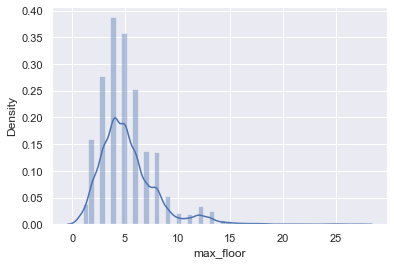

In [66]:
sns.distplot(current_df['max_floor']);

Here we will impute values basing on mean value (around 25% of data is missing). However, a better approach is to stratify and find similar data rows so that we know the floors. Then, we have descriptions which we did not assume yet.

WARNING: We have to be sure that the data we impute is semantically correct (make sense). We cannot insert a mean value of 5 for the row where the floor is higher than the mean!

In [67]:
mean_floor = int(np.median(current_df['max_floor'].dropna().to_numpy().astype('int')))
mean_floor

5

In [68]:
def get_imputed_floor(current_floor, mean_floor):
    
    
    if current_floor > mean_floor:
        candidate_floor_i = np.argmax(floors_ordered > current_floor)
        if candidate_floor_i == 1:
            return current_floor
        
        else:
            return floors_ordered[candidate_floor_i]
    else:
        return mean_floor
    

In [69]:

current_df['max_floor_imputed'] = current_df['max_floor']

current_df.loc[current_df['max_floor'].isna(), 'max_floor_imputed'] = current_df.loc[current_df['max_floor'].isna(), 'floor'].apply(lambda _a: get_imputed_floor(_a, mean_floor))

In [70]:
current_df['max_floor_imputed'].value_counts(dropna=False)

5     2057
4     1267
5     1172
3      905
6      827
2      521
7      446
8      441
9      172
7      128
1      124
12     113
13      81
10      68
11      66
8       54
9       30
14      27
15      18
11      13
10       9
17       9
16       9
18       8
12       8
25       4
17       3
14       3
21       2
27       2
20       2
21       2
18       2
13       2
22       2
24       1
19       1
1        1
Name: max_floor_imputed, dtype: int64

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


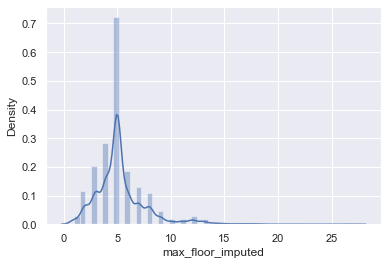

In [71]:
current_df['max_floor_imputed'] = current_df['max_floor_imputed'].astype(int)

sns.distplot(current_df['max_floor_imputed']);

We have plotted the distributions so that we see that we did not harm it much with values imputation. However, the better way is to get this information from description. 

#### Vybavení

In [72]:
current_df['Vybavení:'].value_counts(dropna=False)

NaN             6535
Částečně    2065
Name: Vybavení:, dtype: int64

Vybaveni is needed to be analysed more

#### Energetická náročnost budovy:

In [73]:
current_df['Energetická náročnost budovy:'].value_counts(dropna=False)

Třída G - Mimořádně nehospodárná                                      2401
NaN                                                                          1474
Třída G - Mimořádně nehospodárná č. 78/2013 Sb. podle vyhlášky     1023
Třída G - Mimořádně nehospodárná č. 264/2020 Sb. podle vyhlášky     686
Třída G - Mimořádně nehospodárná č. 148/2007 Sb. podle vyhlášky     459
Třída C - Úsporná                                                         407
Třída C - Úsporná č. 78/2013 Sb. podle vyhlášky                        366
Třída B - Velmi úsporná č. 78/2013 Sb. podle vyhlášky                  261
Třída B - Velmi úsporná                                                   224
Třída D - Méně úsporná č. 78/2013 Sb. podle vyhlášky                 220
Třída D - Méně úsporná                                                  212
Třída E - Nehospodárná                                                    158
Třída E - Neho

Standardize these strings so that we have 7 unique values. 

NaN values will be changed for G. However, a better approach is to parse the description.

In [74]:
current_df.loc[current_df['Energetická náročnost budovy:'].isna(), 'Energetická náročnost budovy:'] = 'Třída G - Mimořádně nehospodárná'

In [75]:
current_df['Energetická náročnost budovy:'].value_counts(dropna=False)

Třída G - Mimořádně nehospodárná                                      3875
Třída G - Mimořádně nehospodárná č. 78/2013 Sb. podle vyhlášky     1023
Třída G - Mimořádně nehospodárná č. 264/2020 Sb. podle vyhlášky     686
Třída G - Mimořádně nehospodárná č. 148/2007 Sb. podle vyhlášky     459
Třída C - Úsporná                                                         407
Třída C - Úsporná č. 78/2013 Sb. podle vyhlášky                        366
Třída B - Velmi úsporná č. 78/2013 Sb. podle vyhlášky                  261
Třída B - Velmi úsporná                                                   224
Třída D - Méně úsporná č. 78/2013 Sb. podle vyhlášky                 220
Třída D - Méně úsporná                                                  212
Třída E - Nehospodárná                                                    158
Třída E - Nehospodárná č. 78/2013 Sb. podle vyhlášky                   153
Třída C - Úsp

In [76]:
def standardize_energy(energy_level_str):
    return energy_level_str.split('-')[0].strip()

current_df['Energetická náročnost budovy:'] = current_df['Energetická náročnost budovy:'].map(standardize_energy)
current_df['Energetická náročnost budovy:'].value_counts(dropna=False)

Třída G    6043
Třída C    1009
Třída B     574
Třída D     526
Třída E     338
Třída A      61
Třída F      49
Name: Energetická náročnost budovy:, dtype: int64

#### Rooms

In [77]:
current_df['rooms'].value_counts(dropna=False)

2+kk     2260
2+1      1714
1+kk     1450
1+1       987
3+1       941
3+kk      826
4+kk      163
4+1       128
pokoj      93
5+kk       20
5+1        18
Name: rooms, dtype: int64

Rooms are OK, we have already parsed them.

### Decide which columns to take from the dataset to put into prediction

In [78]:
COLUMNS_TO_PROCESS = [
    'price',
    'price_log',
    'Užitná plocha:',
    'Balkón:',
    'Sklep:',
    'Garáž:',
    'Terasa:',
    'Lodžie:',
    'Parkování:',
    'rooms',
    'Energetická náročnost budovy:',
    'max_floor_imputed',
    'floor',
    'Vlastnictví:',
    'Stav objektu:',
    'Stavba:',
    'location_place',
]

### Facilities

Facilities show the distance to some facility. We can use this information for the prediction. For example, we saw above that price tends to rise when a flat is closer to the metro.

However, here we have to make a domain related decision: how to impute NaN values. Here I put 99999 instead.

In [79]:
COLUMNS_WITH_FACILITIES = [
    'Cukrárna', 'Kino',
    'Hřiště', 'Večerka', 'Hospoda', 'Divadlo', 'Veterinář', 'Školka',
    'Tram', 'Bus MHD', 'Restaurace', 'Škola', 'Sportoviště', 'Obchod',
    'Lékař', 'Lékárna', 'Vlak', 'Bankomat', 'Pošta', 'Metro',
    'Přírodní zajímavost'
]

COLUMNS_WITH_FACILITIES_binary = [
    _facility + '_binary' for _facility in COLUMNS_WITH_FACILITIES
]

See how many NaNs we have

In [80]:
current_df[COLUMNS_WITH_FACILITIES].isna().sum().reset_index(name='unique_values').set_index('index').T

index          Cukrárna  Kino  Hřiště  Večerka  Hospoda  Divadlo  Veterinář  \
unique_values      1979  2349    1827     1830     1841     3076       1973   

index          Školka  Tram  Bus MHD  Restaurace  Škola  Sportoviště  Obchod  \
unique_values    1836  1826     1826        1831   1832         1861    2419   

index          Lékař  Lékárna  Vlak  Bankomat  Pošta  Metro  \
unique_values   1849     1900  1955      1912   1827   1826   

index          Přírodní zajímavost  
unique_values                 5498

Impute NaN with 99999 -> very distant

In [81]:
current_df.loc[:, COLUMNS_WITH_FACILITIES] = current_df[COLUMNS_WITH_FACILITIES].fillna(99999)

Here I show some feature engineering. We create binary feature saying if the facility is "close" to the flat. Closeness is defined by a distance threshold, which is set by a user basing on domain knowledge and experimentation: the model can be more accurate with different values of this parameter. It's called a hyperparameter of prediction.

In [82]:
DISTANCE_THRESHOLD = 300

current_df.loc[:, COLUMNS_WITH_FACILITIES_binary] = (current_df[COLUMNS_WITH_FACILITIES] < DISTANCE_THRESHOLD).to_numpy()

current_df.loc[:, COLUMNS_WITH_FACILITIES_binary]

Cukrárna_binary  Kino_binary  Hřiště_binary  Večerka_binary  \
0                True        False          False           False   
1                True         True          False            True   
2                True        False           True            True   
3                True         True           True            True   
4                True         True          False            True   
...               ...          ...            ...             ...   
8595            False        False          False           False   
8596            False        False          False           False   
8597            False        False           True            True   
8598            False        False          False           False   
8599            False        False          False           False   

      Hospoda_binary  Divadlo_binary  Veterinář_binary  Školka_binary  \
0              False           False             False          False   
1               True            True             False           True   
2               True           False             False          False   
3               True           False             False           True   
4               True           False              True           True   
...              ...             ...               ...            ...   
8595           False           False             False          False   
8596           False           False             False          False   
8597            True           False             False          False   
8598           False           False             False          False   
8599           False           False             False          False   

      Tram_binary  Bus MHD_binary  Restaurace_binary  Škola_binary  \
0           False            True               True         False   
1            True            True               True          True   
2            True           False               True          True   
3           False           False               True          True   
4            True            True               True          True   
...           ...             ...                ...           ...   
8595        False           False              False         False   
8596        False           False              False         False   
8597        False            True               True          True   
8598        False           False              False         False   
8599        False            True              False          True   

      Sportoviště_binary  Obchod_binary  Lékař_binary  Lékárna_binary  \
0                  False           True         False            True   
1                   True          False          True            True   
2                   True          False          True            True   
3                  False           True          True           False   
4                   True          False          True            True   
...                  ...            ...           ...             ...   
8595               False          False         False           False   
8596               False          False         False           False   
8597                True          False         False           False   
8598               False          False         False           False   
8599               False          False          True            True   

      Vlak_binary  Bankomat_binary  Pošta_binary  Metro_binary  \
0           False             True         False         False   
1           False             True          True         False   
2           False             True         False         False   
3            True             True          True         False   
4           False             True         False         False   
...           ...              ...           ...           ...   
8595        False            False         False         False   
8596        False            False         False      

### Regression

In [83]:
# To supress scientific notation

np.set_printoptions(suppress=True)


First of all, we have to take only those columns we are sure that contain correct and full information. We cannot predict on NaN values and be sure our predictions are good enough.

In [84]:
regression_dataset = current_df[COLUMNS_TO_PROCESS + COLUMNS_WITH_FACILITIES]
regression_dataset

price  price_log  Užitná plocha:  Balkón:  Sklep:  Garáž:  Terasa:  \
0     12500   9.433484              42      0.0     0.0     0.0      0.0   
1     11000   9.305651              40      0.0     0.0     0.0     20.0   
2     10200   9.230143              29      0.0     0.0     0.0      0.0   
3      7500   8.922658              45      0.0     0.0     0.0      0.0   
4     11500   9.350102              32      0.0     0.0     0.0      0.0   
...     ...        ...             ...      ...     ...     ...      ...   
8595  25000  10.126631             124      0.0     0.0     0.0      0.0   
8596  12900   9.464983              67      2.0     0.0     0.0      0.0   
8597   8500   9.047821             110      0.0     0.0     0.0      4.0   
8598  15000   9.615805              57      0.0     0.0     0.0      0.0   
8599   6900   8.839277              20      0.0     0.0     0.0      0.0   

      Lodžie:  Parkování:  rooms Energetická náročnost budovy:  \
0         0.0         0.0   1+kk                     Třída G   
1         0.0         0.0   2+kk                     Třída G   
2         0.0         0.0    1+1                     Třída G   
3         0.0         0.0   2+kk                     Třída G   
4         0.0         0.0    1+1                     Třída G   
...       ...         ...    ...                           ...   
8595      0.0         0.0    2+1                     Třída G   
8596      4.0         0.0    2+1                     Třída G   
8597      0.0         0.0   2+kk                     Třída G   
8598      4.0         0.0   2+kk                     Třída C   
8599      0.0         1.0  pokoj                     Třída G   

      max_floor_imputed  floor Vlastnictví:    Stav objektu:     Stavba:  \
0                     8      5      Osobní       Novostavba    Cihlová   
1                     5      2      Osobní     Velmi dobrý    Cihlová   
2                     3      1      Osobní           Dobrý    Cihlová   
3                     5      1      Osobní     Velmi dobrý    Cihlová   
4                     6      4      Osobní     Velmi dobrý    Cihlová   
...                 ...    ...          ...              ...         ...   
8595                  7      6      Osobní     Velmi dobrý    Cihlová   
8596                  5      3      Osobní  Po rekonstrukci    Cihlová   
8597                  2      2      Osobní     Velmi dobrý    Cihlová   
8598                  6      5      Osobní     Velmi dobrý  Skeletová   
8599                  2      1      Osobní           Dobrý    Cihlová   

               location_place  Cukrárna     Kino   Hřiště  Večerka  Hospoda  \
0                        Brno     122.0   1375.0    605.0    724.0    721.0   
1                      Plzeň      98.0    171.0    346.0      7.0    184.0   
2                        Brno      72.0    714.0    286.0    200.0     40.0   
3                     Dačice       0.0     62.0    144.0    130.0     73.0   
4                        Brno       0.0    295.0    341.0    120.0    150.0   
...                       ...       ...      ...      ...      ...      ...   
8595                  Praha 2   99999.0  99999.0  99999.0  99999.0  99999.0   
8596                     Brno   99999.0  99999.0  99999.0  99999.0  99999.0   
8597                 Dobšice    1238.0   2280.0    267.0    243.0    231.0   
8598                  Praha 9   99999.0  99999.0  99999.0  99999.0  99999.0   
8599  Valašské Meziříčí     995.0   1358.0    507.0    351.0    527.0   

      Divadlo  Veterinář   Školka     Tram  Bus MHD  Restaurace    Škola  \
0       966.0      394.0    460.0    301.0     48.0       139.0    480.0   
1       190.0      468.0     96.0    127.0    176.0        63.0    110.0   
2       685.0      386.0    320.0    176.0    422.0       133.0    262.0   
3     99999.0      462.0    234.0  99999.0    377.0       156.0    103.0   
4       328.0       71.0    278.0    183.0    169.0       

Then, we convert categorical values into "dummy" binary values with the help of one-hot encoding.

In [85]:
regression_dataset_prepared = pd.get_dummies(regression_dataset)
regression_dataset_prepared

price  price_log  Užitná plocha:  Balkón:  Sklep:  Garáž:  Terasa:  \
0     12500   9.433484              42      0.0     0.0     0.0      0.0   
1     11000   9.305651              40      0.0     0.0     0.0     20.0   
2     10200   9.230143              29      0.0     0.0     0.0      0.0   
3      7500   8.922658              45      0.0     0.0     0.0      0.0   
4     11500   9.350102              32      0.0     0.0     0.0      0.0   
...     ...        ...             ...      ...     ...     ...      ...   
8595  25000  10.126631             124      0.0     0.0     0.0      0.0   
8596  12900   9.464983              67      2.0     0.0     0.0      0.0   
8597   8500   9.047821             110      0.0     0.0     0.0      4.0   
8598  15000   9.615805              57      0.0     0.0     0.0      0.0   
8599   6900   8.839277              20      0.0     0.0     0.0      0.0   

      Lodžie:  Parkování:  max_floor_imputed  floor  Cukrárna     Kino  \
0         0.0         0.0                  8      5     122.0   1375.0   
1         0.0         0.0                  5      2      98.0    171.0   
2         0.0         0.0                  3      1      72.0    714.0   
3         0.0         0.0                  5      1       0.0     62.0   
4         0.0         0.0                  6      4       0.0    295.0   
...       ...         ...                ...    ...       ...      ...   
8595      0.0         0.0                  7      6   99999.0  99999.0   
8596      4.0         0.0                  5      3   99999.0  99999.0   
8597      0.0         0.0                  2      2    1238.0   2280.0   
8598      4.0         0.0                  6      5   99999.0  99999.0   
8599      0.0         1.0                  2      1     995.0   1358.0   

       Hřiště  Večerka  Hospoda  Divadlo  Veterinář   Školka     Tram  \
0       605.0    724.0    721.0    966.0      394.0    460.0    301.0   
1       346.0      7.0    184.0    190.0      468.0     96.0    127.0   
2       286.0    200.0     40.0    685.0      386.0    320.0    176.0   
3       144.0    130.0     73.0  99999.0      462.0    234.0  99999.0   
4       341.0    120.0    150.0    328.0       71.0    278.0    183.0   
...       ...      ...      ...      ...        ...      ...      ...   
8595  99999.0  99999.0  99999.0  99999.0    99999.0  99999.0  99999.0   
8596  99999.0  99999.0  99999.0  99999.0    99999.0  99999.0  99999.0   
8597    267.0    243.0    231.0   2212.0     2209.0    302.0  99999.0   
8598  99999.0  99999.0  99999.0  99999.0    99999.0  99999.0  99999.0   
8599    507.0    351.0    527.0   1255.0     1193.0    524.0  99999.0   

      Bus MHD  Restaurace    Škola  Sportoviště   Obchod    Lékař  Lékárna  \
0        48.0       139.0    480.0        460.0    163.0    402.0    163.0   
1       176.0        63.0    110.0        249.0    618.0     89.0     47.0   
2       422.0       133.0    262.0        133.0    704.0    133.0    153.0   
3       377.0       156.0    103.0        397.0    192.0    284.0    660.0   
4       169.0        71.0    232.0        255.0    373.0    166.0    175.0   
...       ...         ...      ...          ...      ...      ...      ...   
8595  99999.0     99999.0  99999.0      99999.0  99999.0  99999.0  99999.0   
8596  99999.0     99999.0  99999.0      99999.0  99999.0  99999.0  99999.0   
8597    143.0       220.0    253.0        231.0   1139.0   1691.0   1238.0   
8598  99999.0     99999.0  99999.0      99999.0  99999.0  99999.0  99999.0   
8599    140.0       351.0    288.0        579.0   1775.0    288.0    288.0   

         Vlak  Bankomat    Pošta    Metro  Přírodní zajímavost  rooms_1+1  \
0      1644.0     113.0    702.0  99999.0               1699.0          0   
1       890.0      49.0    290.0  99999.0              99999.0          0   
2       986.0     165.0    421.0  99999.0               3516.0          1   
3       231.0      16.0    247.0  99999.0              99999.0          0   
4    

Drop columns that we will predict (here we will choose only one).

In [86]:
X = regression_dataset_prepared.drop(['price_log', 'price'], axis=1)
X

Užitná plocha:  Balkón:  Sklep:  Garáž:  Terasa:  Lodžie:  Parkování:  \
0                 42      0.0     0.0     0.0      0.0      0.0         0.0   
1                 40      0.0     0.0     0.0     20.0      0.0         0.0   
2                 29      0.0     0.0     0.0      0.0      0.0         0.0   
3                 45      0.0     0.0     0.0      0.0      0.0         0.0   
4                 32      0.0     0.0     0.0      0.0      0.0         0.0   
...              ...      ...     ...     ...      ...      ...         ...   
8595             124      0.0     0.0     0.0      0.0      0.0         0.0   
8596              67      2.0     0.0     0.0      0.0      4.0         0.0   
8597             110      0.0     0.0     0.0      4.0      0.0         0.0   
8598              57      0.0     0.0     0.0      0.0      4.0         0.0   
8599              20      0.0     0.0     0.0      0.0      0.0         1.0   

      max_floor_imputed  floor  Cukrárna     Kino   Hřiště  Večerka  Hospoda  \
0                     8      5     122.0   1375.0    605.0    724.0    721.0   
1                     5      2      98.0    171.0    346.0      7.0    184.0   
2                     3      1      72.0    714.0    286.0    200.0     40.0   
3                     5      1       0.0     62.0    144.0    130.0     73.0   
4                     6      4       0.0    295.0    341.0    120.0    150.0   
...                 ...    ...       ...      ...      ...      ...      ...   
8595                  7      6   99999.0  99999.0  99999.0  99999.0  99999.0   
8596                  5      3   99999.0  99999.0  99999.0  99999.0  99999.0   
8597                  2      2    1238.0   2280.0    267.0    243.0    231.0   
8598                  6      5   99999.0  99999.0  99999.0  99999.0  99999.0   
8599                  2      1     995.0   1358.0    507.0    351.0    527.0   

      Divadlo  Veterinář   Školka     Tram  Bus MHD  Restaurace    Škola  \
0       966.0      394.0    460.0    301.0     48.0       139.0    480.0   
1       190.0      468.0     96.0    127.0    176.0        63.0    110.0   
2       685.0      386.0    320.0    176.0    422.0       133.0    262.0   
3     99999.0      462.0    234.0  99999.0    377.0       156.0    103.0   
4       328.0       71.0    278.0    183.0    169.0        71.0    232.0   
...       ...        ...      ...      ...      ...         ...      ...   
8595  99999.0    99999.0  99999.0  99999.0  99999.0     99999.0  99999.0   
8596  99999.0    99999.0  99999.0  99999.0  99999.0     99999.0  99999.0   
8597   2212.0     2209.0    302.0  99999.0    143.0       220.0    253.0   
8598  99999.0    99999.0  99999.0  99999.0  99999.0     99999.0  99999.0   
8599   1255.0     1193.0    524.0  99999.0    140.0       351.0    288.0   

      Sportoviště   Obchod    Lékař  Lékárna     Vlak  Bankomat    Pošta  \
0           460.0    163.0    402.0    163.0   1644.0     113.0    702.0   
1           249.0    618.0     89.0     47.0    890.0      49.0    290.0   
2           133.0    704.0    133.0    153.0    986.0     165.0    421.0   
3           397.0    192.0    284.0    660.0    231.0      16.0    247.0   
4           255.0    373.0    166.0    175.0   1188.0      66.0    671.0   
...           ...      ...      ...      ...      ...       ...      ...   
8595      99999.0  99999.0  99999.0  99999.0  99999.0   99999.0  99999.0   
8596      99999.0  99999.0  99999.0  99999.0  99999.0   99999.0  99999.0   
8597        231.0   1139.0   1691.0   1238.0   1825.0    1377.0     40.0   
8598      99999.0  99999.0  99999.0  99999.0  99999.0   99999.0  99999.0   
8599        579.0   1775.0    288.0    288.0   1813.0     288.0    368.0   

        Metro  Přírodní zajímavost  rooms_1+1  rooms_1+kk  rooms_2+1  \
0     99999.0               1699.0          0           1          0   
1     99999.0              99999.0          0           0          0   
2     99999.0               3516.0          1         

Different prediction methods have different assumptions. For example, classical linear regression says that the target variable has to be normally distributed. Then, we can trust linear regression coefficients and statistics. However, here I leave price as target variable, not price_log, so that I can interpret metrics normally across different models.

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


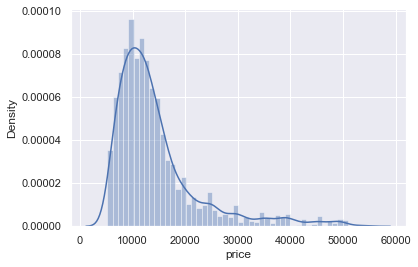

In [87]:
# sns.distplot(regression_dataset_prepared['price_log']);
sns.distplot(regression_dataset_prepared['price']);

Prepare target variable

In [88]:
y = regression_dataset_prepared['price'].to_numpy()
y

array([12500, 11000, 10200, ...,  8500, 15000,  6900])

Split dataset to train and test sets.

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#### Linear regression

Train a linear regression model on OLSE method and see the importance of each variable. We also print two basic metrics: Mean squared error (how the model is penalised) and root mean squared error so that we can interpret the values basing on the same units as in target variable.

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train,y_train)

# #Calculate intercept and coefficient
# print(model.intercept_)
# print(model.coef_)

pred=model.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  8.960593826109053e+17
RMSE :  946604131.9426539


In [91]:
for a, b in zip(list(X_train.columns), model.coef_.reshape(-1).tolist()):
    print(f'{a:20}:\t\t\t{b:20}')

Užitná plocha:      :			  150.66634930734207
Balkón:             :			  160.53065108032123
Sklep:              :			 -28.035059504177315
Garáž:              :			   634.3551040168013
Terasa:             :			   58.88802248264512
Lodžie:             :			   -64.7166010114985
Parkování:          :			   3.274994450716976
max_floor_imputed   :			  25.653808389802315
floor               :			   50.77412683955365
Cukrárna            :			-0.0008387618048457668
Kino                :			-0.008111950585446337
Hřiště              :			-0.07488228907818595
Večerka             :			 0.05153347358888816
Hospoda             :			0.0010453544074593424
Divadlo             :			-0.00030386907110369066
Veterinář           :			0.014592007671492269
Školka              :			-0.04661094250368336
Tram                :			-0.025691089583254723
Bus MHD             :			  0.6995781188239789
Restaurace          :			-0.0046954256534519345
Škola               :			  0.0634065803646422
Sportoviště         :			-0.007834920826894631

We see that our model trained very badly. The reason could be in some outlier and unmet assumptions of the model, which are pretty strict. We will see one such bad prediction

In [92]:
print(f'Correct: {y_test[180][0]}, predicted: {predictions[180][0]}')

Correct: 8300, predicted: 6990184601.1269


### KNN regressor

We take a regressor which does not have such strict assumptions - KNN regressor (k-nearest neighbors).

It is extremely important to say that most models have some parameters. For example, KNN has K as parameter - how many neighbors to look at while decising predicted value. The correct value of the parameter is subject to further experimentation, cross validation and tests.

In [93]:
from sklearn.neighbors import KNeighborsRegressor

# k = 3

neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)

pred=neigh.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  25823284.31511628
RMSE :  5081.6615703051575


In [94]:
# k = 10

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

pred=neigh.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  26299843.610761624
RMSE :  5128.337314448185


In [95]:
# k = 100

neigh = KNeighborsRegressor(n_neighbors=100)
neigh.fit(X_train, y_train)

pred=neigh.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  30399905.464670643
RMSE :  5513.610927937393


### DecisionTreeRegressor

In [96]:
from sklearn.tree import DecisionTreeRegressor

In [97]:
# max_depth=2

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X_train, y_train)

pred=regr_1.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  39450101.493373364
RMSE :  6280.931578466157


In [98]:
max_depth=5

regr_1 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)

pred=regr_1.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  23014226.04698347
RMSE :  4797.314461965514


In [99]:
# max_depth=10

regr_1 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_train, y_train)

pred=regr_1.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  19329823.46345239
RMSE :  4396.569510817769


In [100]:
# max_depth=20

regr_1 = DecisionTreeRegressor(max_depth=20)
regr_1.fit(X_train, y_train)

pred=regr_1.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  24458815.895033326
RMSE :  4945.585495675242


### Ridge

Linear regression with regularization: better parameters estimation by not allowing them to grow "too much"

Alpha parameter is used to choose how much emphasis to put on regularization: 0 means normal linear regression.

In [101]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.5)

reg.fit(X_train, y_train)

pred=reg.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  20396362.65641164
RMSE :  4516.233237600959


### Lasso

Feature selection regression: we do not allow parameters to grow by minimization of parameters L1 norm instead of L2 norm as in Ridge regression. L1 norm is |x - y| -> absolute values make several parameters become 0 in order to be minimised.

Alpha parameter is used to choose how much emphasis to put on regularization: 0 means normal linear regression.

In [102]:
from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.5)

reg.fit(X_train, y_train)

pred=reg.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))

MSE :  17918847.17599302
RMSE :  4233.065930976391


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58356936340.00925, tolerance: 47906792.4905436
  model = cd_fast.enet_coordinate_descent(


In [103]:
for a, b in zip(list(X_train.columns), reg.coef_.reshape(-1).tolist()):
    print(f'{a:50}:{b:20.5f}')

Užitná plocha:                                    :           148.94527
Balkón:                                           :           162.39145
Sklep:                                            :           -29.12842
Garáž:                                            :           644.51814
Terasa:                                           :            58.65734
Lodžie:                                           :           -56.84538
Parkování:                                        :             3.02412
max_floor_imputed                                 :            40.36662
floor                                             :            51.09330
Cukrárna                                          :            -0.00590
Kino                                              :            -0.00497
Hřiště                                            :            -0.03070
Večerka                                           :             0.03918
Hospoda                                           :             

### Neural network

In [104]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(50, 25))

reg.fit(X_train, y_train)

pred=reg.predict(X_test)
predictions = pred.reshape(-1,1)

print('MSE : ', mean_squared_error(y_test,predictions))
print('RMSE : ', np.sqrt(mean_squared_error(y_test,predictions)))


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_2022/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE :  35484754.565448575
RMSE :  5956.908138073692


Prediction is a rabbit hole. There are so many things to do here, but unfortunately it would become a separate course by itself. So, here I showed just very basics of the prediction.

In order to get better results you can provide better data: parse descriptions, parse HTML pages with pictures in tables. Play around with features, delete several of them or create new ones as I showed in the notebook. Feel free to improve the result!